In [2]:
# Crypto Buy-Sell
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from datetime import datetime


# Get_data,clean and set it up into a dataframe
def BM_data(): # Benchmark data
    start_date = datetime(2017,1,1) 
    end_date = datetime(2020,7,31)
    try:
        data = pd.DataFrame()
        data = web.DataReader('BTC-USD', 'yahoo',start_date,end_date)[['Open','Adj Close']]
    except KeyError:
        pass
    return data

short_window = 10
long_window = 50
BM = BM_data()
BM['Date'] = BM.index
BM.drop_duplicates(subset = 'Date', keep = 'first',inplace = True)
BM.set_index('Date',inplace = True)
BM_data_returns = BM['Adj Close'].pct_change()
BM_data_returns.fillna(0,inplace = True) # can change 0 to something else as well 
short_rolling = BM['Adj Close'].rolling(window = short_window).mean()
long_rolling = BM['Adj Close'].rolling(window = long_window).mean()


fig,ax = plt.subplots(figsize = (16,9))

ax.plot(BM['Adj Close'].index, BM['Adj Close'].values, label = 'Price')
ax.plot(long_rolling.index, long_rolling.values, label = '50-days SMA')
ax.plot(short_rolling.index, short_rolling.values, label = '10-days SMA')
ax.legend(loc = 'best')
ax.set_ylabel('Price in $')

#plt.show()


data = pd.concat([BM,short_rolling,long_rolling],axis = 1)
data.columns = ['BMC_OPEN','BMC_CLOSE','Short Rolling','Long Rolling']
data['Lagged Short Rolling'] = data['Short Rolling'].shift(1)
data['Lagged Long Rolling'] = data['Long Rolling'].shift(1)
data['Signal'] = 0
data.dropna(inplace = True)


# data ready for Signal Generation


                                        

In [3]:
"Trading Signal"
# This function will generate a buy sell signal along with trailing stop loss prices 
def Buy_Sell(df): 
  # Generate Buy Sell Signal only based on Moving average condition  
    df['Signal'] = df.apply(lambda x:1 if (x['Short Rolling'] > x['Long Rolling'] 
                           and x['Lagged Short Rolling'] <= x['Lagged Long Rolling']) 
                            else (-1 if (x['Short Rolling'] < x['Long Rolling']
                                 and x['Lagged Short Rolling'] >= x['Lagged Long Rolling']) else np.nan),axis = 1) 
    df['Position'] = df['Signal']
    df['Position'].ffill(inplace = True)
    df['Reason for Closing'] = df.apply(lambda x: 'Reverse Signal' if (x['Signal'] == 1 or x['Signal']==-1) 
                                        else np.nan, axis =1) # Only Reverse Signal, Stop Loss will be mentioned later

    # Create groups for buy and sell so that trailing Stop Loss conditions can be used for trades                               
    df['Buy_Signal']= np.where(data['Position']==1,1,np.nan)  
    df['Buy_Signal_Temp'] = df.apply(lambda x: 1 if x['Reason for Closing'] == 'Reverse Signal' 
                                     and x['Buy_Signal']==1 else(0 if x['Reason for Closing'] !='Reverse Signal' 
                                     and x['Buy_Signal']==1 else np.nan),axis =1 )

    df['Buy_Group'] = df['Buy_Signal_Temp'].cumsum()
    df['Buy_Stop_Loss'] = df.groupby('Buy_Group').BMC_CLOSE.cummax()*0.9 # trailing stop loss for long trade 
    df['Buy_Stop_Loss'].fillna(0,inplace =True)
    df['Sell_Signal']= np.where(df['Position']==-1,-1,np.nan)  
    df['Sell_Signal_Temp'] = df.apply(lambda x: -1 if x['Reason for Closing'] == 'Reverse Signal' 
                                     and x['Sell_Signal']==-1 else(0 if x['Reason for Closing'] !='Reverse Signal' 
                                     and x['Sell_Signal']==-1 else np.nan),axis =1 )

    df['Sell_Group'] = df['Sell_Signal_Temp'].cumsum()
    df['Sell_Stop_Loss'] = df.groupby('Sell_Group').BMC_CLOSE.cummin()*1.1 # trailing stop loss for short trade 
    df['Sell_Stop_Loss'].fillna(0,inplace = True)
    df['Stop_Loss_Price'] = df['Buy_Stop_Loss']+df['Sell_Stop_Loss']
    df['Stop_Loss_Price_Lagged'] = df['Stop_Loss_Price'].shift(1)
    df['Position_2'] = df.apply(lambda x: 0 if ((x['Position']==1 
                                                and x['Reason for Closing']!='Reverse Signal' 
                                                 and x['BMC_CLOSE'] < x['Stop_Loss_Price_Lagged']) 
                                                or (x['Position']== -1 
                                                and x['Reason for Closing']!='Reverse Signal' 
                                                 and x['BMC_CLOSE'] > x['Stop_Loss_Price_Lagged'])) 
                                else x['Position'],axis =1)
    # logic for the above step - We denote exit by 0 and we want 0 where stop loss limits are triggered and 
    #not where reverse signals are present
    
    df.iloc[-1,-1] =0  # Exit at the last data point
    return df

# +1,-1 signal generated at the end of the day so Reason for closing is valid at the end of the day but 
#Entry price will be on next open 


Buy_Sell = Buy_Sell(data)



In [248]:

# Compute Daily Returns, Strategy Returns 

def Daily_Profit(d):
    Profit = pd.DataFrame()
    Profit = d[['BMC_OPEN','BMC_CLOSE','Reason for Closing','Position_2']] 
    Profit['BMC_CLOSE_Lagged'] = Profit['BMC_CLOSE'].shift(1)
    Profit['BMC_OPEN_Forward'] = Profit['BMC_OPEN'].shift(-1)
    Profit['Position_2_Lagged'] = Profit['Position_2'].shift(1)
    Profit['Reason for Closing Lagged'] = Profit['Reason for Closing'].shift(1)
    Profit['Daily_Returns'] = Profit['BMC_CLOSE'].pct_change()# Buy and Hold Benchmark
    Profit['Entry Price'] = Profit.apply(lambda x: x['BMC_OPEN_Forward'] if x['Reason for Closing'] == 'Reverse Signal' or  (abs(x['Position_2'])==1  and x['Position_2_Lagged']==0 
                                      and x['Reason for Closing'] != 'Reverse Signal') else 0, axis =1) # Entry price based on next open price
    Profit['Entry Price'].fillna(0,inplace = True)
    Profit['Entry price_Lagged'] = Profit['Entry Price'].shift(1)
    Profit['Daily_PnL']=Profit.apply(lambda x: (x['BMC_CLOSE']-x['BMC_OPEN'])/x['BMC_OPEN'] if x['Entry price_Lagged']!=0
                                  else x['Daily_Returns'], axis =1) # position opened on next buy hence the first condition 
   
    Profit['Strategy_Returns'] = Profit['Daily_PnL']*Profit['Position_2'].shift(1) # strategy returns 
    return Profit 

PnL = Daily_Profit(Buy_Sell)

/Users/kp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/kp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/kp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

In [284]:
# Compute profit per trade 
# Step 1 compute the exit points for Stop Loss Trigger

def Exit_Price(d,p):
    Exit= pd.DataFrame()
    df = pd.DataFrame(p['Entry Price'])
    Exit = d[['Position','Position_2','BMC_CLOSE','Stop_Loss_Price','Reason for Closing']]
    Exit = pd.concat([Exit,df],axis =1 )
    Exit['Position_2_Lagged'] = Exit['Position_2'].shift(1)
    Exit['Exit_Indicator'] = Exit.apply(lambda x: 1 if (x['Position_2'] == 0 and abs(x['Position_2_Lagged']) == 1) 
                                         else 0,axis =1) 
    # logic for above  we want only those cases where a +1 or -1 is followed by 0 
    Exit['Exit_Price'] = Exit.apply(lambda x:x['BMC_CLOSE'] if x['Exit_Indicator']==1 else 0,axis = 1) # here we find multi
    idx = np.where(Exit['Exit_Price']>0)
    d['Reason for Closing'].iloc[idx] = 'Stop Loss Triggered'
    temp = Exit[['Entry Price','Exit_Price']]
    temp['Date'] = temp.index 
    d['Date'] = d.index
    d = d.merge(temp,how = 'left',on = 'Date')
    d.set_index(d['Date'],inplace = True)
    return Exit,d
Ex = Exit_Price(Buy_Sell,PnL)

def Profit_Per_Trade(Exit):
    
    idx = np.where((Exit['Entry Price']>0) | (Exit['Exit_Price']>0))
    Profit_Per_Trade = Exit.iloc[idx]
    Profit_Per_Trade.drop(['Position','BMC_CLOSE','Stop_Loss_Price',
                       'Exit_Indicator','Reason for Closing','Position_2']
                      ,axis = 1,inplace = True)
    Profit_Per_Trade['Entry Price Lagged'] = Profit_Per_Trade['Entry Price'].shift(1)
    Profit_Per_Trade['Profit_Per_Trade'] = Profit_Per_Trade.apply(lambda x: (x['Entry Price']-x['Entry Price Lagged'])*x['Position_2_Lagged'] if (x['Entry Price']>0 
                                            and x['Entry Price Lagged']>0) else( (x['Exit_Price']-x['Entry Price Lagged'])*x['Position_2_Lagged'] if (x['Exit_Price']>0 
                                          and x['Entry Price Lagged']>0) else 0), axis=1)
    
    return Profit_Per_Trade

Profit = Profit_Per_Trade(Ex[0])
data_Final = Ex[1]
data_Final = data_Final.iloc[:,[6,8,19,21,22]]
data_Final = data_Final.fillna("")

print(data_Final)

/Users/kp/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/kp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/Users/kp/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 

           Signal   Reason for Closing Position_2  Entry Price    Exit_Price
Date                                                                        
2017-02-19                                            0.000000      0.000000
2017-02-20                                            0.000000      0.000000
2017-02-21                                            0.000000      0.000000
2017-02-22                                            0.000000      0.000000
2017-02-23                                            0.000000      0.000000
2017-02-24                                            0.000000      0.000000
2017-02-25                                            0.000000      0.000000
2017-02-26                                            0.000000      0.000000
2017-02-27                                            0.000000      0.000000
2017-02-28                                            0.000000      0.000000
2017-03-01                                            0.000000      0.000000

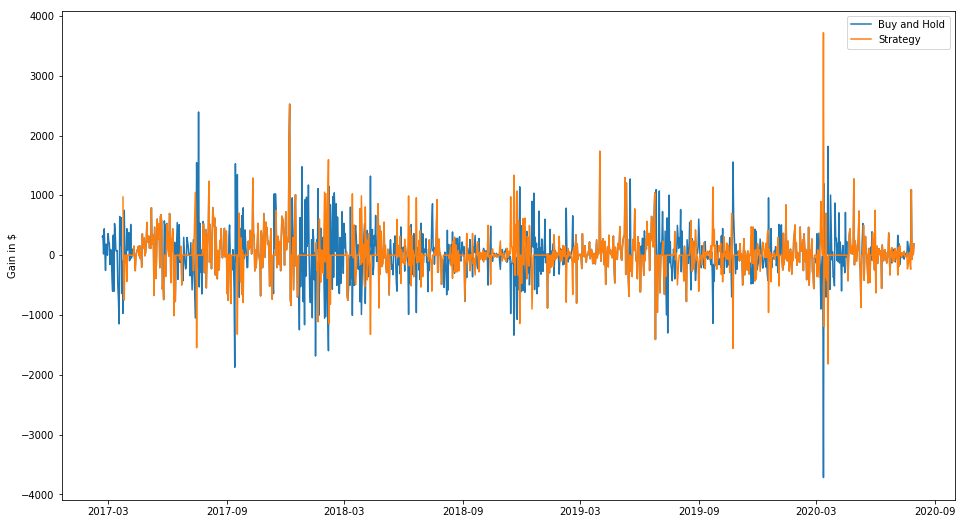

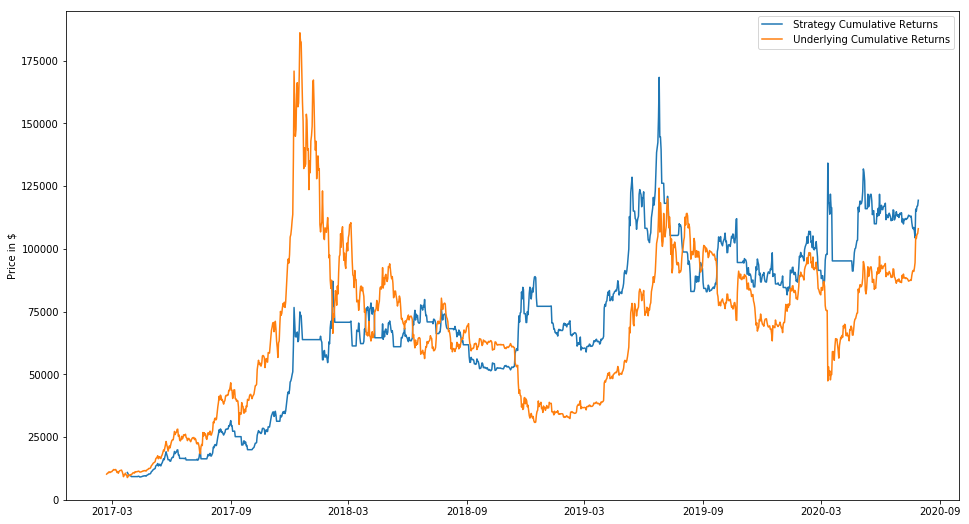

None


In [202]:
def Plot_Total_Returns(d):
    Initial_Capital = 10000
    Returns = pd.DataFrame()
    Returns = d[['Daily_Returns','Strategy_Returns']]
    cum_returns_s = np.cumprod(Returns['Strategy_Returns']+1,axis =0)*Initial_Capital
    cum_returns_n =  np.cumprod(Returns['Daily_Returns']+1,axis = 0)*Initial_Capital
    fig_1,ax_1 = plt.subplots(figsize = (16,9))
    ax_1.plot(Returns['Daily_Returns'].index, Returns['Daily_Returns'].values*Initial_Capital, label = 'Buy and Hold')
    ax_1.plot(Returns['Strategy_Returns'].index, Returns['Strategy_Returns'].values*Initial_Capital, label = 'Strategy')
    ax_1.legend(loc = 'best')
    ax_1.set_ylabel('Gain in $')
    fig_2,ax_2 = plt.subplots(figsize = (16,9))
    ax_2.plot(cum_returns_s.index, cum_returns_s.values, label = ' Strategy Cumulative Returns')
    ax_2.plot(cum_returns_n.index, cum_returns_n.values, label = ' Underlying Cumulative Returns')
    ax_2.legend(loc = 'best')
    ax_2.set_ylabel('Price in $')
    plt.show()
print(Plot_Total_Returns(PnL))

In [257]:
#Metrics

Total_Return_Benchmark = np.prod(1+PnL['Daily_Returns'])
Total_Return_Strategy = np.prod(1+PnL['Strategy_Returns'])
def Annualized_Return (d):
    Total_return = np.prod(d+1,axis =0)
    return Total_return**(252/len(d))-1

Annualized_Returns_Strategy = Annualized_Return(PnL['Strategy_Returns'])
Annualized_Returns_Benchmark = Annualized_Return(PnL['Daily_Returns'])

Annualized_Volatility_Strategy = np.std(PnL['Strategy_Returns'])*np.sqrt(252)
Annualized_Volatility_Benchmark = np.std(PnL['Daily_Returns'])*np.sqrt(252)

/Users/kp/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5430: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


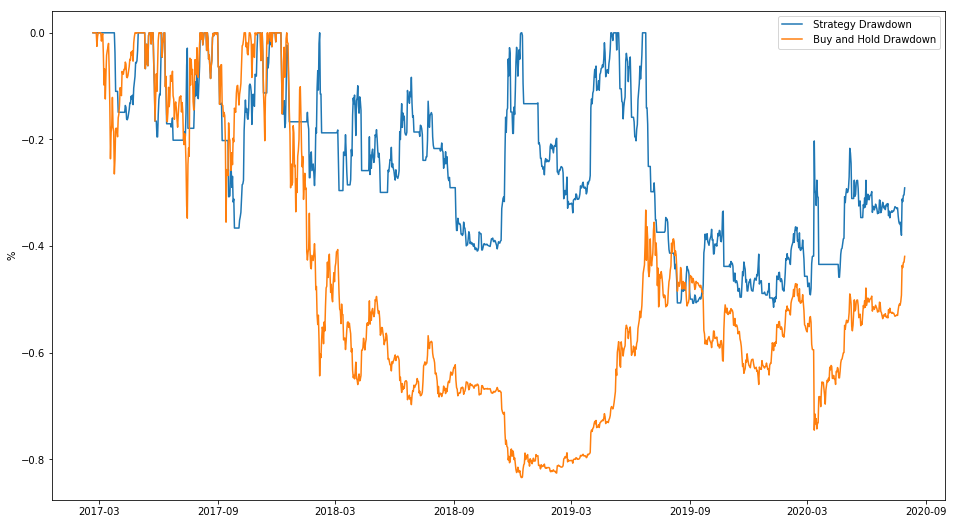

-0.8339900882218974


In [255]:

# Sharpe Ratio 
def Sharpe(d):
    return np.mean(d)/np.std(d)*np.sqrt(252)

Strategy_Sharpe = Sharpe(PnL['Strategy_Returns'])
Benchmark_Sharpe = Sharpe(PnL['Daily_Returns'])

def drawdown(r):
    r.fillna(0,inplace = True)
    cum_r = np.cumprod(1+r)
    running_max = np.maximum.accumulate(cum_r)
    running_max[running_max<1] = 1
    d = cum_r/running_max-1
    return d


fig_3,ax_3 = plt.subplots(figsize = (16,9))
ax_3.plot(drawdown(PnL['Strategy_Returns']).index, drawdown(PnL['Strategy_Returns']), label = ' Strategy Drawdown')
ax_3.plot(drawdown(PnL['Daily_Returns']).index, drawdown(PnL['Daily_Returns']), label = ' Buy and Hold Drawdown')
ax_3.legend(loc = 'best')
ax_3.set_ylabel('%')
plt.show()

Max_Drawdown_Benchmark = drawdown(PnL['Daily_Returns']).min()
Max_Drawdown_Strategy = drawdown(PnL['Strategy_Returns']).min()


print(Max_Drawdown_Benchmark)

/Users/kp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  
/Users/kp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


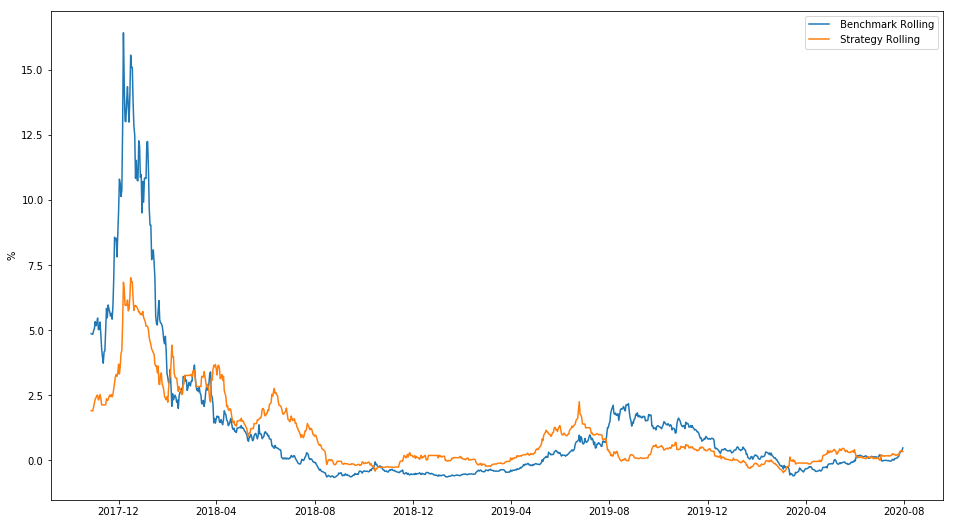

In [207]:
# Rolling Returns
Rolling_Return_Benchmark = PnL['Daily_Returns'].rolling(252).apply(Annualized_Return)
Rolling_Return_Strategy = PnL['Strategy_Returns'].rolling(252).apply(Annualized_Return)
fig_4,ax_4 = plt.subplots(figsize = (16,9))
ax_4.plot(Rolling_Return_Benchmark.index, Rolling_Return_Benchmark, label = ' Benchmark Rolling')
ax_4.plot(Rolling_Return_Strategy.index, Rolling_Return_Strategy, label = ' Strategy Rolling')
ax_4.legend(loc = 'best')
ax_4.set_ylabel('%')
plt.show()



In [283]:
# Monte-Carlo VaR 
Mu_Benchmark = np.mean(PnL['Daily_Returns'])
Mu_Strategy = np.mean(PnL['Strategy_Returns'])

Vol_Benchmark = np.std(PnL['Daily_Returns'])
Vol_Strategy = np.std(PnL['Strategy_Returns'])

def Monte_Carlo_VaR(d,N,mu,sig):
    Yearly_loss = np.zeros(N)
    Yearly_loss = [ sum([mu+(sig*np.random.normal(0,1,252))]) for i in range (N)]
    return Yearly_loss,np.percentile(Yearly_loss,0.95) 
   
MC_VaR_BM = Monte_Carlo_VaR(PnL['Daily_Returns'],10000,Mu_Benchmark,Vol_Benchmark)
MC_VaR_Yearly_BM = MC_VaR_BM[1]
MC_VaR_S = Monte_Carlo_VaR(PnL['Strategy_Returns'],10000,Mu_Strategy,Vol_Strategy)
MC_VaR_Yearly_S = MC_VaR_S[1]

def Monte_Carlo_CVar(d):
    d=np.array(d)
    mask = d<np.percentile(d,0.95)
    loss = np.mean(d[mask])
    return loss

MC_CVaR_Yearly_BM = Monte_Carlo_CVar(MC_VaR_BM[0])
MC_CVaR_Yearly_S = Monte_Carlo_CVar(MC_VaR_S[0])
Metrics_BM = [Total_Return_Benchmark,Annualized_Returns_Benchmark,Annualized_Volatility_Benchmark,Max_Drawdown_Benchmark,Benchmark_Sharpe,
             MC_VaR_Yearly_BM,MC_CVaR_Yearly_BM]
Metrics_S = [Total_Return_Strategy,Annualized_Returns_Strategy,Annualized_Volatility_Strategy,Max_Drawdown_Strategy,Strategy_Sharpe,MC_VaR_Yearly_S,MC_CVaR_Yearly_S ]
Metrics = list(zip(Metrics_BM,Metrics_S))
Comparison = pd.DataFrame(Metrics,columns = ['Benchmark','Strategy'],index = ['Total Returns','Annualized Returns','Annualized Volatility','Max Drawdown','Sharpe Ratio','Annual_VaR','Annual_CVaR'])
print(Comparison)

                       Benchmark   Strategy
Total Returns          10.806175  11.937266
Annualized Returns      0.612717   0.645277
Annualized Volatility   0.687530   0.560876
Max Drawdown           -0.833990  -0.514607
Sharpe Ratio            1.043763   1.178126
Annual_VaR             -0.098884  -0.080271
Annual_CVaR            -0.113552  -0.092051
